In [1]:
# Import modules
import numpy as N
import matplotlib.pyplot as P
import matplotlib
import time
import gc
import scipy.integrate as spi
from skimage.measure import find_contours
from math import *
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy import interpolate

# Import my figure routines
from figure_module import *

import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)


/usr/licensed/anaconda3/2020.11/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: Support for setting the 'text.latex.preamble' or 'pgf.preamble' rcParam to a list of strings is deprecated since 3.3 and will be removed two minor releases later; set it to a single string instead.
  self[key] = other[key]


In [2]:
# Connect patch indices and names
sphere = {0: "A", 1: "B", 2: "C", 3: "D", 4: "N", 5: "S"}

class Sphere:
    A = 0
    B = 1
    C = 2
    D = 3
    N = 4
    S = 5

# Parameters
cfl = 0.6
Nxi = 128
Neta = 128
NG = 1 # Number of ghosts zones
xi_min, xi_max = - N.pi / 4.0, N.pi / 4.0
eta_min, eta_max = - N.pi / 4.0, N.pi / 4.0
dxi = (xi_max - xi_min) / Nxi
deta = (eta_max - eta_min) / Neta

In [3]:
# Define grids
xi  = N.arange(- NG - int(Nxi / 2), NG + int(Nxi / 2), 1) * dxi
eta = N.arange(- NG - int(Neta / 2), NG + int(Neta / 2), 1) * deta
eta_grid, xi_grid = N.meshgrid(eta, xi)
xi_yee  = xi  + 0.5 * dxi
eta_yee = eta + 0.5 * deta

# Initialize fields
Er  = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
E1u = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
E2u = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
Br  = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
B1u = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
B2u = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))

E1d = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
E2d = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
B1d = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
B2d = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))

In [4]:
# Define metric tensor
########

g11d = N.empty((Nxi + 2 * NG, Neta + 2 * NG, 4))
g12d = N.empty((Nxi + 2 * NG, Neta + 2 * NG, 4))
g22d = N.empty((Nxi + 2 * NG, Neta + 2 * NG, 4))

for i in range(Nxi + 2 * NG):
    for j in range(Neta + 2 * NG):
        
        # 0 at (i, j)
        X = N.tan(xi[i])
        Y = N.tan(eta[j])
        C = N.sqrt(1.0 + X * X)
        D = N.sqrt(1.0 + Y * Y)
        delta = N.sqrt(1.0 + X * X + Y * Y)
        
        g11d[i, j, 0] = (C * C * D / (delta * delta))**2
        g22d[i, j, 0] = (C * D * D / (delta * delta))**2
        g12d[i, j, 0] = - X * Y * C * C * D * D / (delta)**4
        
        # 1 at (i + 1/2, j)
        X = N.tan(xi_yee[i])
        Y = N.tan(eta[j])
        C = N.sqrt(1.0 + X * X)
        D = N.sqrt(1.0 + Y * Y)
        delta = N.sqrt(1.0 + X * X + Y * Y)
        
        g11d[i, j, 1] = (C * C * D / (delta * delta))**2
        g22d[i, j, 1] = (C * D * D / (delta * delta))**2
        g12d[i, j, 1] = - X * Y * C * C * D * D / (delta)**4
        
        # 2 at (i, j + 1/2)
        X = N.tan(xi[i])
        Y = N.tan(eta_yee[j])
        C = N.sqrt(1.0 + X * X)
        D = N.sqrt(1.0 + Y * Y)
        delta = N.sqrt(1.0 + X * X + Y * Y)
        
        g11d[i, j, 2] = (C * C * D / (delta * delta))**2
        g22d[i, j, 2] = (C * D * D / (delta * delta))**2
        g12d[i, j, 2] = - X * Y * C * C * D * D / (delta)**4

        # 3 at (i + 1/2, j + 1/2)
        X = N.tan(xi_yee[i])
        Y = N.tan(eta_yee[j])
        C = N.sqrt(1.0 + X * X)
        D = N.sqrt(1.0 + Y * Y)
        delta = N.sqrt(1.0 + X * X + Y * Y)
        
        g11d[i, j, 3] = (C * C * D / (delta * delta))**2
        g22d[i, j, 3] = (C * D * D / (delta * delta))**2
        g12d[i, j, 3] = - X * Y * C * C * D * D / (delta)**4

sqrt_det_g = N.sqrt(g11d * g22d - g12d * g12d)

dt = cfl * N.min(1.0 / N.sqrt(g11d / (sqrt_det_g * sqrt_det_g) / (dxi * dxi) + g22d / (sqrt_det_g * sqrt_det_g) / (deta * deta) ))
print("delta t = {}".format(dt))

delta t = 0.004215883958057442


In [5]:
# Single-patch push routines
########

def contra_to_cov_E(patch):
    
    i0, i1 = NG, Nxi + NG
    j0, j1 = NG, Neta + NG
             
    E1d[patch, i0:i1, j0:j1] = g11d[i0:i1, j0:j1, 1] * E1u[patch, i0:i1, j0:j1] + \
                         0.5 * g12d[i0:i1, j0:j1, 1] * (E2u[patch, i0:i1, j0:j1] + N.roll(N.roll(E2u, -1, axis = 1), 1, axis = 2)[patch, i0:i1, j0:j1])
    E2d[patch, i0:i1, j0:j1] = g22d[i0:i1, j0:j1, 2] * E2u[patch, i0:i1, j0:j1] + \
                         0.5 * g12d[i0:i1, j0:j1, 2] * (E1u[patch, i0:i1, j0:j1] + N.roll(N.roll(E1u, 1, axis = 1), -1, axis = 2)[patch, i0:i1, j0:j1])

def contra_to_cov_B(patch):

    i0, i1 = NG, Nxi + NG 
    j0, j1 = NG, Neta + NG
    
    B1d[patch, i0:i1, j0:j1] = g11d[i0:i1, j0:j1, 2] * B1u[patch, i0:i1, j0:j1] + \
                         0.5 * g12d[i0:i1, j0:j1, 2] * (B2u[patch, i0:i1, j0:j1] + N.roll(N.roll(B2u, 1, axis = 1), -1, axis = 2)[patch, i0:i1, j0:j1])            
    B2d[patch, i0:i1, j0:j1] = g22d[i0:i1, j0:j1, 1] * B2u[patch, i0:i1, j0:j1] + \
                         0.5 * g12d[i0:i1, j0:j1, 1] * (B1u[patch, i0:i1, j0:j1] + N.roll(N.roll(B1u, -1, axis = 1), 1, axis = 2)[patch, i0:i1, j0:j1])

def push_B(patch):
    
    i0, i1 = NG, Nxi + NG
    j0, j1 = NG, Neta + NG
    
    Br[patch, i0:i1, j0:j1]  -= ((N.roll(E2d, -1, axis = 1)[patch, i0:i1, j0:j1] - E2d[patch, i0:i1, j0:j1]) / dxi - \
                                 (N.roll(E1d, -1, axis = 2)[patch, i0:i1, j0:j1] - E1d[patch, i0:i1, j0:j1]) / deta) \
                                * dt / sqrt_det_g[i0:i1, j0:j1, 3]
    B1u[patch, i0:i1, j0:j1] -= ((N.roll(Er, -1, axis = 2)[patch, i0:i1, j0:j1] - Er[patch, i0:i1, j0:j1]) / deta) * dt / sqrt_det_g[i0:i1, j0:j1, 2]
    B2u[patch, i0:i1, j0:j1] += ((N.roll(Er, -1, axis = 1)[patch, i0:i1, j0:j1] - Er[patch, i0:i1, j0:j1]) / dxi)  * dt / sqrt_det_g[i0:i1, j0:j1, 1]

def push_E(it, patch):
    
    i0, i1 = NG, Nxi + NG
    j0, j1 = NG, Neta + NG
    
    Er[patch, i0:i1, j0:j1] += ((B2d[patch, i0:i1, j0:j1] - N.roll(B2d, 1, axis = 1)[patch, i0:i1, j0:j1]) / dxi - \
                                (B1d[patch, i0:i1, j0:j1] - N.roll(B1d, 1, axis = 2)[patch, i0:i1, j0:j1]) / deta) \
                               * dt / sqrt_det_g[i0:i1, j0:j1, 0] - 4.0 * N.pi * dt * Jr(it, patch, i0, i1, j0, j1) 
    E1u[patch, i0:i1, j0:j1] += ((Br[patch, i0:i1, j0:j1] - N.roll(Br, 1, axis = 2)[patch, i0:i1, j0:j1]) / deta) * dt / sqrt_det_g[i0:i1, j0:j1, 1]
    E2u[patch, i0:i1, j0:j1] -= ((Br[patch, i0:i1, j0:j1] - N.roll(Br, 1, axis = 1)[patch, i0:i1, j0:j1]) / dxi)  * dt / sqrt_det_g[i0:i1, j0:j1, 2]

In [6]:
# Topology of the patches
########

topology = N.array([
    [   0, 'xx',    0,    0, 'yx',    0],
    [   0,    0, 'xy',    0, 'yy',    0],
    [   0,    0,    0, 'yy',    0, 'xy'],
    ['yx',    0,    0,    0,    0, 'xx'],
    [   0,    0, 'xx', 'yx',    0,    0],
    ['yy', 'xy',    0,    0,    0,    0]
                    ])


In [7]:
# Generic coordinate transformation
########

from coord_transformations_flip import *

def transform_coords(patch0, patch1, xi0, eta0):
    fcoord0 = (globals()["coord_" + sphere[patch0] + "_to_sph"])
    fcoord1 = (globals()["coord_sph_to_" + sphere[patch1]])
    return fcoord1(*fcoord0(xi0, eta0))

# Generic vector transformation 
########

from vec_transformations_flip import *

def transform_vect(patch0, patch1, xi0, eta0, vxi0, veta0):
    fcoord0 = (globals()["coord_" + sphere[patch0] + "_to_sph"])
    theta0, phi0 = fcoord0(xi0, eta0)
    fvec0 = (globals()["vec_" + sphere[patch0] + "_to_sph"])
    fvec1 = (globals()["vec_sph_to_" + sphere[patch1]])
    return fvec1(theta0, phi0, *fvec0(xi0, eta0, vxi0, veta0))

# Linear form transformations
########

from form_transformations_flip import *

def transform_form(patch0, patch1, xi0, eta0, vxi0, veta0):
    fcoord0 = (globals()["coord_" + sphere[patch0] + "_to_sph"])
    theta0, phi0 = fcoord0(xi0, eta0)
    fform0 = (globals()["form_" + sphere[patch0] + "_to_sph"])
    fform1 = (globals()["form_sph_to_" + sphere[patch1]])
    return fform1(theta0, phi0, *fform0(xi0, eta0, vxi0, veta0))

In [8]:
# Interpolation routines
########

# def interp(arr, x0, x):
    
#     i0 = N.argmin(N.abs(x - x0))
#     if (x0 > x[i0]):
#         i_min = i0
#         i_max = i0 + 1
#     else:
#         i_min = i0 - 1
#         i_max = i0

#     if (i_max == Nxi + 2 * NG):
#         return arr[i_min]
#     else:
#         # Define weight coefficients for interpolation
#         w1 = (x0 - x[i_min]) / (x[i_max] - x[i_min])
#         w2 = (x[i_max] - x0) / (x[i_max] - x[i_min])

#         return (w1 * arr[i_max] + w2 * arr[i_min]) / (w1 + w2)

def interp(arr_in, xA, xB):
    f = interpolate.interp1d(xA, arr_in, kind='linear', fill_value=(0,0), bounds_error=False)
    return f(xB)

In [40]:
# Source current
########

theta0, phi0 = 90.0 / 360.0 * 2.0 * N.pi, 270.0 / 360.0 * 2.0 * N.pi # Center of the wave packet !60
x0 = N.sin(theta0) * N.cos(phi0)
y0 = N.sin(theta0) * N.sin(phi0)
z0 = N.cos(theta0)

def shape_packet(x, y, z, width):
    return N.exp(- y * y / (width * width)) * N.exp(- x * x / (width * width)) * N.exp(- z * z / (width * width)) 

w = 0.1 # Radius of wave packet
omega = 20.0 # Frequency of current
J0 = 1.0 # Current amplitude
p0 = Sphere.D # Patch location of antenna

Jr_tot = N.zeros_like(Er)

for patch in range(6):

    fcoord0 = (globals()["coord_" + sphere[patch] + "_to_sph"])
    for i in range(Nxi + 2 * NG):
        for j in range(Neta + 2 * NG):
            th, ph = fcoord0(xi_grid[i, j], eta_grid[i, j])
            x = N.sin(th) * N.cos(ph)
            y = N.sin(th) * N.sin(ph)
            z = N.cos(th)        
     
            Jr_tot[patch, i, j] = J0 * shape_packet(x - x0, y - y0, z - z0, w) * int(patch == p0)

def Jr(it, patch, i0, i1, j0, j1):
    return Jr_tot[patch, i0:i1, j0:j1] * N.sin(omega * dt * it)


In [41]:
########
# Communication at between two patches
########

# patch0 has the open boundary
# patch1 has the closed boundary 
          
def communicate_E_patch(patch0, patch1):
        
    top = topology[patch0, patch1]
    if (top == 0):
        return
    
    elif (top == 'xx'):
            
            #########
            # Communicate fields from xi right edge of patch0 to xi left edge patch1
            ########
            
            # SINGLE COMMUNICATOR
            
            xi1 = xi_grid[1,:] - 0.5 * dxi
            eta1 = eta_grid[1,:] + 0.0 * deta
            
            xi0, eta0 = transform_coords(patch1, patch0, xi1, eta1)
            
            E1u0 = interp(E1u[patch0, -2, :], eta, eta0)
            E2u0 = interp(E2u[patch0, -2, :], eta_yee, eta0)
            
            E1u[patch1, 0, :] = transform_vect(patch0, patch1, xi0, eta0, E1u0, E2u0)[0]
            
            # SINGLE COMMUNICATOR
            
            xi1 = xi_grid[1,:] - 0.5 * dxi
            eta1 = eta_grid[1,:] + 0.0 * deta
            
            xi0, eta0 = transform_coords(patch1, patch0, xi1, eta1)
            
            E1d0 = interp(E1d[patch0, -2, :], eta, eta0)
            E2d0 = interp(E2d[patch0, -2, :], eta_yee, eta0)
            
            E1d[patch1, 0, :] = transform_form(patch0, patch1, xi0, eta0, E1d0, E2d0)[0]
                
            #########
            # Communicate fields from xi left edge of patch1 to xi right edge of patch0
            ########
            
            # SINGLE COMMUNICATOR
            
            xi0 = xi_grid[-1,:] + 0.0 * dxi
            eta0 = eta_grid[-1,:] + 0.5 * deta
            
            xi1, eta1 = transform_coords(patch0, patch1, xi0, eta0)
            
            E1u1 = interp(E1u[patch1, 1, :], eta, eta1)
            E2u1 = interp(E2u[patch1, 1, :], eta_yee, eta1)
            
            E2u[patch0, -1, :] = transform_vect(patch1, patch0, xi1, eta1, E1u1, E2u1)[1]
            
            # SINGLE COMMUNICATOR
            
            xi0 = xi_grid[-1,:] + 0.0 * dxi
            eta0 = eta_grid[-1,:] + 0.5 * deta
            
            xi1, eta1 = transform_coords(patch0, patch1, xi0, eta0)
            
            E1d1 = interp(E1d[patch1, 1, :], eta, eta1)
            E2d1 = interp(E2d[patch1, 1, :], eta_yee, eta1)
            
            E2d[patch0, -1, :] = transform_form(patch1, patch0, xi1, eta1, E1d1, E2d1)[1]
            
            # SINGLE COMMUNICATOR
            
            xi0 = xi_grid[-1,:] + 0.0 * dxi
            eta0 = eta_grid[-1,:] + 0.0 * deta
            
            xi1, eta1 = transform_coords(patch0, patch1, xi0, eta0)
            
            Er1 = interp(Er[patch1, 1, :], eta, eta1)
            Er[patch0, -1, :] = Er1
                
    elif (top == 'xy'):
            
            #########
            # Communicate fields from xi right edge of patch0 to eta left edge patch1
            ########
            
            # SINGLE COMMUNICATOR
            
            xi1 = xi_grid[:,1] + 0.0 * dxi
            eta1 = eta_grid[:,1] - 0.5 * deta
            
            xi0, eta0 = transform_coords(patch1, patch0, xi1, eta1)
            
            E1u0 = interp(E1u[patch0, -2, :], eta, eta0)
            E2u0 = interp(E2u[patch0, -2, :], eta_yee, eta0)
            
            E2u[patch1, :, 0] = transform_vect(patch0, patch1, xi0, eta0, E1u0, E2u0)[1]
            
            # SINGLE COMMUNICATOR
            
            xi1 = xi_grid[:,1] + 0.0 * dxi
            eta1 = eta_grid[:,1] - 0.5 * deta
            
            xi0, eta0 = transform_coords(patch1, patch0, xi1, eta1)
            
            E1d0 = interp(E1d[patch0, -2, :], eta, eta0)
            E2d0 = interp(E2d[patch0, -2, :], eta_yee, eta0)
            
            E2d[patch1, :, 0] = transform_form(patch0, patch1, xi0, eta0, E1d0, E2d0)[1]
                
            #########
            # Communicate fields from eta left edge of patch1 to xi right edge of patch0
            ########
            
            # SINGLE COMMUNICATOR
            
            xi0 = xi_grid[-1,:] + 0.0 * dxi
            eta0 = eta_grid[-1,:] + 0.5 * deta
            
            xi1, eta1 = transform_coords(patch0, patch1, xi0, eta0)
            
            E1u1 = interp(E1u[patch1, :, 1], xi_yee, xi1)
            E2u1 = interp(E2u[patch1, :, 1], xi, xi1)
            
            E2u[patch0, -1, :] = transform_vect(patch1, patch0, xi1, eta1, E1u1, E2u1)[1]
            
            # SINGLE COMMUNICATOR
            
            xi0 = xi_grid[-1,:] + 0.0 * dxi
            eta0 = eta_grid[-1,:] + 0.5 * deta
            
            xi1, eta1 = transform_coords(patch0, patch1, xi0, eta0)
            
            E1d1 = interp(E1d[patch1, :, 1], xi_yee, xi1)
            E2d1 = interp(E2d[patch1, :, 1], xi, xi1)
            
            E2d[patch0, -1, :] = transform_form(patch1, patch0, xi1, eta1, E1d1, E2d1)[1]
            
            # SINGLE COMMUNICATOR
            
            xi0 = xi_grid[-1,:] + 0.0 * dxi
            eta0 = eta_grid[-1,:] + 0.0 * deta
            
            xi1, eta1 = transform_coords(patch0, patch1, xi0, eta0)
            
            Er1 = interp(Er[patch1, :, 1], xi, xi1)
            Er[patch0, -1, :] = Er1
            
    elif (top == 'yy'):
        
            #########
            # Communicate fields from eta right edge of patch0 to eta left edge patch1
            ########
            
            # SINGLE COMMUNICATOR
            
            xi1 = xi_grid[:,1] + 0.0 * dxi
            eta1 = eta_grid[:,1] - 0.5 * deta
            
            xi0, eta0 = transform_coords(patch1, patch0, xi1, eta1)
            
            E1u0 = interp(E1u[patch0, :, -2], xi_yee, xi0)
            E2u0 = interp(E2u[patch0, :, -2], xi, xi0)
            
            E2u[patch1, :, 0] = transform_vect(patch0, patch1, xi0, eta0, E1u0, E2u0)[1]
            
            # SINGLE COMMUNICATOR
            
            xi1 = xi_grid[:,1] + 0.0 * dxi
            eta1 = eta_grid[:,1] - 0.5 * deta
            
            xi0, eta0 = transform_coords(patch1, patch0, xi1, eta1)
            
            E1d0 = interp(E1d[patch0, :, -2], xi_yee, xi0)
            E2d0 = interp(E2d[patch0, :, -2], xi, xi0)
            
            E2d[patch1, :, 0] = transform_form(patch0, patch1, xi0, eta0, E1d0, E2d0)[1]

            #########
            # Communicate fields from eta left edge of patch1 to eta right edge of patch0
            ########
            
            # SINGLE COMMUNICATOR
            
            xi0 = xi_grid[:, -1] + 0.5 * dxi
            eta0 = eta_grid[:, -1] + 0.0 * deta
            
            xi1, eta1 = transform_coords(patch0, patch1, xi0, eta0)
            
            E1u1 = interp(E1u[patch1, :, 1], xi_yee, xi1)
            E2u1 = interp(E2u[patch1, :, 1], xi, xi1)
            
            E1u[patch0, :, -1] = transform_vect(patch1, patch0, xi1, eta1, E1u1, E2u1)[0]
            
            # SINGLE COMMUNICATOR
            
            xi0 = xi_grid[:, -1] + 0.5 * dxi
            eta0 = eta_grid[:, -1] + 0.0 * deta
            
            xi1, eta1 = transform_coords(patch0, patch1, xi0, eta0)
            
            E1d1 = interp(E1d[patch1, :, 1], xi_yee, xi1)
            E2d1 = interp(E2d[patch1, :, 1], xi, xi1)
            
            E1d[patch0, :, -1] = transform_form(patch1, patch0, xi1, eta1, E1d1, E2d1)[0]
            
            # SINGLE COMMUNICATOR
            
            xi0 = xi_grid[:,-1] + 0.0 * dxi
            eta0 = eta_grid[:,-1] + 0.0 * deta
            
            xi1, eta1 = transform_coords(patch0, patch1, xi0, eta0)
            
            Er1 = interp(Er[patch1, :, 1], xi, xi1)
            Er[patch0, :, -1] = Er1
            

    elif (top == 'yx'):

            #########
            # Communicate fields from eta right edge of patch0 to xi left edge patch1
            ########
            
            # SINGLE COMMUNICATOR
            
            xi1 = xi_grid[1,:] - 0.5 * dxi
            eta1 = eta_grid[1,:] - 0.0 * deta
            
            xi0, eta0 = transform_coords(patch1, patch0, xi1, eta1)
            
            E1u0 = interp(E1u[patch0, :, -2], xi_yee, xi0)
            E2u0 = interp(E2u[patch0, :, -2], xi, xi0)
            
            E1u[patch1, 0, :] = transform_vect(patch0, patch1, xi0, eta0, E1u0, E2u0)[0]
            
            # SINGLE COMMUNICATOR
            
            xi1 = xi_grid[1,:] - 0.5 * dxi
            eta1 = eta_grid[1,:] - 0.0 * deta
            
            xi0, eta0 = transform_coords(patch1, patch0, xi1, eta1)
            
            E1d0 = interp(E1d[patch0, :, -2], xi_yee, xi0)
            E2d0 = interp(E2d[patch0, :, -2], xi, xi0)
            
            E1d[patch1, 0, :] = transform_form(patch0, patch1, xi0, eta0, E1d0, E2d0)[0]
                
            #########
            # Communicate fields from eta left edge of patch1 to xi right edge of patch0
            ########
            
            # SINGLE COMMUNICATOR
            
            xi0 = xi_grid[:, -1] + 0.5 * dxi
            eta0 = eta_grid[:, -1] + 0.0 * deta
            
            xi1, eta1 = transform_coords(patch0, patch1, xi0, eta0)
            
            E1u1 = interp(E1u[patch1, 1, :], eta, eta1)
            E2u1 = interp(E2u[patch1, 1, :], eta_yee, eta1)
            
            E1u[patch0, :, -1] = transform_vect(patch1, patch0, xi1, eta1, E1u1, E2u1)[0]
            
            # SINGLE COMMUNICATOR
            
            xi0 = xi_grid[:, -1] + 0.5 * dxi
            eta0 = eta_grid[:, -1] + 0.0 * deta
            
            xi1, eta1 = transform_coords(patch0, patch1, xi0, eta0)
            
            E1d1 = interp(E1d[patch1, 1, :], eta, eta1)
            E2d1 = interp(E2d[patch1, 1, :], eta_yee, eta1)
            
            E1d[patch0, :, -1] = transform_form(patch1, patch0, xi1, eta1, E1d1, E2d1)[0]
            
            # SINGLE COMMUNICATOR
            
            xi0 = xi_grid[:,-1] + 0.0 * dxi
            eta0 = eta_grid[:,-1] + 0.0 * deta
            
            xi1, eta1 = transform_coords(patch0, patch1, xi0, eta0)
            
            Er1 = interp(Er[patch1, 1, :], eta, eta1)
            Er[patch0, :, -1] = Er1 
            


In [42]:
def communicate_B_patch(patch0, patch1):
        
    top = topology[patch0, patch1]
    if (top == 0):
        return

    elif (top == 'xx'):
            
            #########
            # Communicate fields from xi right edge of patch0 to xi left edge patch1
            ########
            
            # SINGLE COMMUNICATOR
            
            xi1 = xi_grid[1,:] - 0.5 * dxi
            eta1 = eta_grid[1,:] + 0.0 * deta
            
            xi0, eta0 = transform_coords(patch1, patch0, xi1, eta1)
            
            B1u0 = interp(B1u[patch0, -2, :], eta_yee, eta0)
            B2u0 = interp(B2u[patch0, -2, :], eta, eta0)
            
            B2u[patch1, 0, :] = transform_vect(patch0, patch1, xi0, eta0, B1u0, B2u0)[1]
            
            # SINGLE COMMUNICATOR
            
            xi1 = xi_grid[1,:] - 0.5 * dxi
            eta1 = eta_grid[1,:] + 0.0 * deta
            
            xi0, eta0 = transform_coords(patch1, patch0, xi1, eta1)
            
            B1d0 = interp(B1d[patch0, -2, :], eta_yee, eta0)
            B2d0 = interp(B2d[patch0, -2, :], eta, eta0)
            
            B2d[patch1, 0, :] = transform_form(patch0, patch1, xi0, eta0, B1d0, B2d0)[1]
                
            #########
            # Communicate fields from xi left edge of patch1 to xi right edge of patch0
            ########
            
            # SINGLE COMMUNICATOR
            
            xi0 = xi_grid[-1,:] + 0.0 * dxi
            eta0 = eta_grid[-1,:] + 0.5 * deta
            
            xi1, eta1 = transform_coords(patch0, patch1, xi0, eta0)
            
            B1u1 = interp(B1u[patch1, 1, :], eta_yee, eta1)
            B2u1 = interp(B2u[patch1, 1, :], eta, eta1)
            
            B1u[patch0, -1, :] = transform_vect(patch1, patch0, xi1, eta1, B1u1, B2u1)[0]
            
            # SINGLE COMMUNICATOR
            
            xi0 = xi_grid[-1,:] + 0.0 * dxi
            eta0 = eta_grid[-1,:] + 0.5 * deta
            
            xi1, eta1 = transform_coords(patch0, patch1, xi0, eta0)
            
            B1d1 = interp(B1d[patch1, 1, :], eta_yee, eta1)
            B2d1 = interp(B2d[patch1, 1, :], eta, eta1)
        
            B1d[patch0, -1, :] = transform_form(patch1, patch0, xi1, eta1, B1d1, B2d1)[0]
            
            # SINGLE COMMUNICATOR
            
            xi1 = xi_grid[1,:] - 0.5 * dxi
            eta1 = eta_grid[1,:] + 0.5 * deta
            
            xi0, eta0 = transform_coords(patch1, patch0, xi1, eta1)
            
            Br0 = interp(Br[patch0, -2, :], eta_yee, eta0)
            Br[patch1, 0, :] = Br0
                
    elif (top == 'xy'):
            
            #########
            # Communicate fields from xi right edge of patch0 to eta left edge patch1
            ########
            
            # SINGLE COMMUNICATOR
            
            xi1 = xi_grid[:,1] + 0.0 * dxi
            eta1 = eta_grid[:,1] - 0.5 * deta
            
            xi0, eta0 = transform_coords(patch1, patch0, xi1, eta1)
            
            B1u0 = interp(B1u[patch0, -2, :], eta_yee, eta0)
            B2u0 = interp(B2u[patch0, -2, :], eta, eta0)
            
            B1u[patch1, :, 0] = transform_vect(patch0, patch1, xi0, eta0, B1u0, B2u0)[0]
            
            # SINGLE COMMUNICATOR
            
            xi1 = xi_grid[:,1] + 0.0 * dxi
            eta1 = eta_grid[:,1] - 0.5 * deta
            
            xi0, eta0 = transform_coords(patch1, patch0, xi1, eta1)
            
            B1d0 = interp(B1d[patch0, -2, :], eta_yee, eta0)
            B2d0 = interp(B2d[patch0, -2, :], eta, eta0)
            
            B1d[patch1, :, 0] = transform_form(patch0, patch1, xi0, eta0, B1d0, B2d0)[0]
                
            #########
            # Communicate fields from eta left edge of patch1 to xi right edge of patch0
            ########
            
            # SINGLE COMMUNICATOR
            
            xi0 = xi_grid[-1,:] + 0.0 * dxi
            eta0 = eta_grid[-1,:] + 0.5 * deta
            
            xi1, eta1 = transform_coords(patch0, patch1, xi0, eta0)
            
            B1u1 = interp(B1u[patch1, :, 1], xi, xi1)
            B2u1 = interp(B2u[patch1, :, 1], xi_yee, xi1)
            
            B1u[patch0, -1, :] = transform_vect(patch1, patch0, xi1, eta1, B1u1, B2u1)[0]
            
            # SINGLE COMMUNICATOR
            
            xi0 = xi_grid[-1,:] + 0.0 * dxi
            eta0 = eta_grid[-1,:] + 0.5 * deta
            
            xi1, eta1 = transform_coords(patch0, patch1, xi0, eta0)
            
            B1d1 = interp(B1d[patch1, :, 1], xi, xi1)
            B2d1 = interp(B2d[patch1, :, 1], xi_yee, xi1)
            
            B1d[patch0, -1, :] = transform_form(patch1, patch0, xi1, eta1, B1d1, B2d1)[0]
            
            # SINGLE COMMUNICATOR
            
            xi1 = xi_grid[:,1] + 0.5 * dxi
            eta1 = eta_grid[:,1] - 0.5 * deta
            
            xi0, eta0 = transform_coords(patch1, patch0, xi1, eta1)
            
            Br0 = interp(Br[patch0, -2, :], eta_yee, eta0)
            Br[patch1, :, 0] = Br0
            
    elif (top == 'yy'):
        
            #########
            # Communicate fields from eta right edge of patch0 to eta left edge patch1
            ########
            
            # SINGLE COMMUNICATOR
            
            xi1 = xi_grid[:,1] + 0.0 * dxi
            eta1 = eta_grid[:,1] - 0.5 * deta
            
            xi0, eta0 = transform_coords(patch1, patch0, xi1, eta1)
            
            B1u0 = interp(B1u[patch0, :, -2], xi, xi0)
            B2u0 = interp(B2u[patch0, :, -2], xi_yee, xi0)
            
            B1u[patch1, :, 0] = transform_vect(patch0, patch1, xi0, eta0, B1u0, B2u0)[0]
            
            # SINGLE COMMUNICATOR
            
            xi1 = xi_grid[:,1] + 0.0 * dxi
            eta1 = eta_grid[:,1] - 0.5 * deta
            
            xi0, eta0 = transform_coords(patch1, patch0, xi1, eta1)
            
            B1d0 = interp(B1d[patch0, :, -2], xi, xi0)
            B2d0 = interp(B2d[patch0, :, -2], xi_yee, xi0)
            
            B1d[patch1, :, 0] = transform_form(patch0, patch1, xi0, eta0, B1d0, B2d0)[0]
                
            #########
            # Communicate fields from eta left edge of patch1 to eta right edge of patch0
            ########
            
            # SINGLE COMMUNICATOR
            
            xi0 = xi_grid[:, -1] + 0.5 * dxi
            eta0 = eta_grid[:, -1] + 0.0 * deta
            
            xi1, eta1 = transform_coords(patch0, patch1, xi0, eta0)
            
            B1u1 = interp(B1u[patch1, :, 1], xi, xi1)
            B2u1 = interp(B2u[patch1, :, 1], xi_yee, xi1)
            
            B2u[patch0, :, -1] = transform_vect(patch1, patch0, xi1, eta1, B1u1, B2u1)[1]
            
            # SINGLE COMMUNICATOR
            
            xi0 = xi_grid[:, -1] + 0.5 * dxi
            eta0 = eta_grid[:, -1] + 0.0 * deta
            
            xi1, eta1 = transform_coords(patch0, patch1, xi0, eta0)
            
            B1d1 = interp(B1d[patch1, :, 1], xi, xi1)
            B2d1 = interp(B2d[patch1, :, 1], xi_yee, xi1)
            
            B2d[patch0, :, -1] = transform_form(patch1, patch0, xi1, eta1, B1d1, B2d1)[1]
            
            # SINGLE COMMUNICATOR
            
            xi1 = xi_grid[:,1] + 0.5 * dxi
            eta1 = eta_grid[:,1] - 0.5 * deta
            
            xi0, eta0 = transform_coords(patch1, patch0, xi1, eta1)
            
            Br0 = interp(Br[patch0, :, -2], xi_yee, xi0)
            Br[patch1, :, 0] = Br0
            

    elif (top == 'yx'):

            #########
            # Communicate fields from eta right edge of patch0 to xi left edge patch1
            ########
            
            # SINGLE COMMUNICATOR
            
            xi1 = xi_grid[1,:] - 0.5 * dxi
            eta1 = eta_grid[1,:] - 0.0 * deta
            
            xi0, eta0 = transform_coords(patch1, patch0, xi1, eta1)
            
            B1u0 = interp(B1u[patch0, :, -2], xi, xi0)
            B2u0 = interp(B2u[patch0, :, -2], xi_yee, xi0)
            
            B2u[patch1, 0, :] = transform_vect(patch0, patch1, xi0, eta0, B1u0, B2u0)[1]
            
            # SINGLE COMMUNICATOR
            
            xi1 = xi_grid[1,:] - 0.5 * dxi
            eta1 = eta_grid[1,:] - 0.0 * deta
            
            xi0, eta0 = transform_coords(patch1, patch0, xi1, eta1)
            
            B1d0 = interp(B1d[patch0, :, -2], xi, xi0)
            B2d0 = interp(B2d[patch0, :, -2], xi_yee, xi0)
            
            B2d[patch1, 0, :] = transform_form(patch0, patch1, xi0, eta0, B1d0, B2d0)[1]
            
            #########
            # Communicate fields from eta left edge of patch1 to xi right edge of patch0
            ########
            
            # SINGLE COMMUNICATOR
            
            xi0 = xi_grid[:, -1] + 0.5 * dxi
            eta0 = eta_grid[:, -1] + 0.0 * deta
            
            xi1, eta1 = transform_coords(patch0, patch1, xi0, eta0)
            
            B1u1 = interp(B1u[patch1, 1, :], eta_yee, eta1)
            B2u1 = interp(B2u[patch1, 1, :], eta, eta1)
            
            B2u[patch0, :, -1] = transform_vect(patch1, patch0, xi1, eta1, B1u1, B2u1)[1]
            
            # SINGLE COMMUNICATOR
            
            xi0 = xi_grid[:, -1] + 0.5 * dxi
            eta0 = eta_grid[:, -1] + 0.0 * deta
            
            xi1, eta1 = transform_coords(patch0, patch1, xi0, eta0)
            
            B1d1 = interp(B1d[patch1, 1, :], eta_yee, eta1)
            B2d1 = interp(B2d[patch1, 1, :], eta, eta1)
            
            B2d[patch0, :, -1] = transform_form(patch1, patch0, xi1, eta1, B1d1, B2d1)[1]
            
            # SINGLE COMMUNICATOR
            
            xi1 = xi_grid[1,:] - 0.5 * dxi
            eta1 = eta_grid[1,:] + 0.5 * deta
            
            xi0, eta0 = transform_coords(patch1, patch0, xi1, eta1)
            
            Br0 = interp(Br[patch0, :, -2], xi_yee, xi0)
            Br[patch1, 0, :] = Br0            


In [43]:
# Initialization
########

# Initialize fields
Er  = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
E1u = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
E2u = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
Br  = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
B1u = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
B2u = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))

E1d = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
E2d = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
B1d = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))
B2d = N.zeros((6, Nxi + 2 * NG, Neta + 2 * NG))

for p in range(6):
    pass # All fields to zero

iter = 0
idump = 0

Nt = 400 # Number of iterations

In [44]:
for it in tqdm(range(Nt)):
    
    for p in range(6):
        contra_to_cov_E(p)
        push_B(p)

    for p0 in range(6):
        for p1 in range(6):
            communicate_B_patch(p0, p1)

    for p in range(6):
        contra_to_cov_B(p)
        push_E(it, p)

    for p0 in range(6):
        for p1 in range(6):
            communicate_E_patch(p0, p1)

100%|██████████| 400/400 [00:17<00:00, 23.08it/s]


In [45]:
# Figure parameters
vm = 0.2
ratio = 2.0

xi_grid_c, eta_grid_c = unflip_eq(xi_grid[NG:(Nxi + NG), NG:(Neta + NG)], eta_grid[NG:(Nxi + NG), NG:(Neta + NG)])
xi_grid_d, eta_grid_d = unflip_eq(xi_grid[NG:(Nxi + NG), NG:(Neta + NG)], eta_grid[NG:(Nxi + NG), NG:(Neta + NG)])
xi_grid_n, eta_grid_n = unflip_po(xi_grid[NG:(Nxi + NG), NG:(Neta + NG)], eta_grid[NG:(Nxi + NG), NG:(Neta + NG)])

def plot_fields_unfolded(it, field, field2, vm):

    fig_size = deffigsize(2.0,0.75)
    fig = P.figure(1, figsize = fig_size, facecolor='w')
    ax = P.subplot(111)
    
    tab = (globals()[field])
    tab1 = (globals()[field2])

    ax.pcolormesh(xi_grid[NG:(Nxi + NG), NG:(Neta + NG)], eta_grid[NG:(Nxi + NG), NG:(Neta + NG)], tab[Sphere.A, NG:(Nxi + NG), NG:(Neta + NG)], cmap = "RdBu_r", vmin = - vm, vmax = vm)
    ax.pcolormesh(xi_grid[NG:(Nxi + NG), NG:(Neta + NG)] + N.pi / 2.0, eta_grid[NG:(Nxi + NG), NG:(Neta + NG)], tab[Sphere.B, NG:(Nxi + NG), NG:(Neta + NG)], cmap = "RdBu_r", vmin = - vm, vmax = vm)
    ax.pcolormesh(xi_grid[NG:(Nxi + NG), NG:(Neta + NG)], eta_grid[NG:(Nxi + NG), NG:(Neta + NG)] - N.pi / 2.0, tab1[Sphere.S, NG:(Nxi + NG), NG:(Neta + NG)], cmap = "RdBu_r", vmin = - vm, vmax = vm)

    ax.pcolormesh(xi_grid_c + N.pi, eta_grid_c, tab1[Sphere.C, NG:(Nxi + NG), NG:(Neta + NG)], cmap = "RdBu_r", vmin = - vm, vmax = vm)
    ax.pcolormesh(xi_grid_d - N.pi / 2.0, eta_grid_d, tab1[Sphere.D, NG:(Nxi + NG), NG:(Neta + NG)], cmap = "RdBu_r", vmin = - vm, vmax = vm)
    ax.pcolormesh(xi_grid_n, eta_grid_n + N.pi / 2.0, tab[Sphere.N, NG:(Nxi + NG), NG:(Neta + NG)], cmap = "RdBu_r", vmin = - vm, vmax = vm)
    
    plt.show()
    ax.cla()

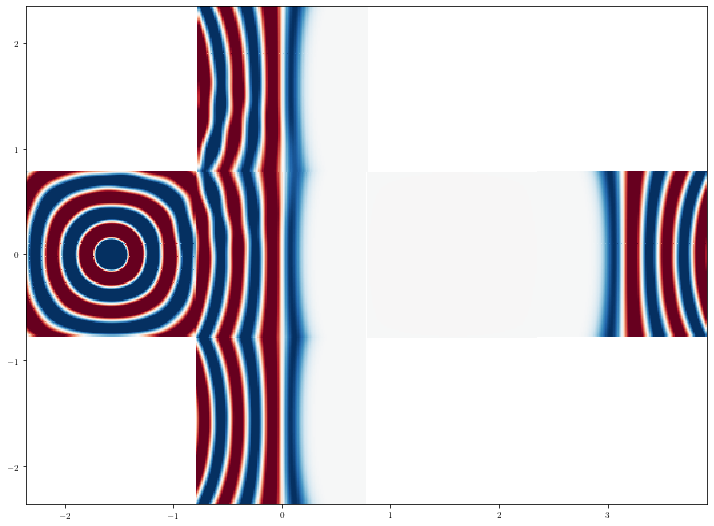

In [46]:
plot_fields_unfolded(1, "Er", "Er", 0.1)